<a href="https://colab.research.google.com/github/nimito135/MachineLearningProjects/blob/main/CrabAge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FRAME THE PROBLEM AND LOOK AT THE BIG PICTURE

The objective of this machine learning project is to create a model that is capable of predicting the age of crabs, based on their physical attributes such as *sex, length, diameter, weight, etc.*

The model will be used by crab farmers to know the correct age of crabs, age is an important factor in deciding whether and when to harvest crabs, this metric has a profound impact on reducing cost and increasing profits.

This project is a supervised learning task, each instance in the training set has its corresponding target value, it is also a regression task, the target attribute can asume a continuous value from $0$ to $\infty$.

The performance of the model will be measured using the *Mean Absolute Error* which is defined by the following equation:

$$MAE=\frac{1}{n}\sum_{i=1}^{n}{|\hat{y}_{i}-y_{i}|}$$

Where:
*   $\hat{y_{i}}$: Predicted age for the $i$th instance.
*   $y_{i}$: Age of $i$th instance.

The model must achieve a *Mean Absolute Error* score of at most $1.4$ to achieve the objective.

#GET THE DATA

The data needed comes from the dataset of Kaggle *Regression with a Crab Age*, which has $3$ sets:

*   *sample_submission.csv*
*   *test.csv*
*   *train.csv*

The space occupied by files is less than $10$Mb.

The files are in *csv* format, which will be converted to DataFrames for easy manipulation with *Pandas*.

##Get access authorizations

In [ ]:
from google.colab import files

In [ ]:
files.upload()

##Create workspace

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir data

#Get the data

In [ ]:
!kaggle competitions download -c playground-series-s3e16

  0% 0.00/2.65M [00:00<?, ?B/s]
100% 2.65M/2.65M [00:00<00:00, 158MB/s]


In [ ]:
!unzip playground-series-s3e16.zip -d data

Archive:  playground-series-s3e16.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


##Convert the data

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
DATA_SETS_PATH = "/content/data"

In [ ]:
def load_data(data_sets_path, data_set):
    """Recovers datasets in CSV format and returns a copy converted into a DataFrame.

    Args:
      data_sets_path: Path which contains all datasets.
      data_set: Specific dataset.

    Returns:
      The copy of the dataset converted in a DataFrame.
    """
    csv_path = os.path.join(data_sets_path, data_set)

    return pd.read_csv(csv_path).copy()

In [ ]:
data_train = load_data(DATA_SETS_PATH, "train.csv")

#EXPLORE THE DATA

In [ ]:
data_train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


There are $10$ attributes, $9$ of which are quantitative and $1$ is qualitative. The target attribute is *Age*.

Size attributes are measured in *Feet*, while weight attributes are measured in *ounces*.
The target attribute *Age* is measured in *months*.

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


There are $74,051$ instances, and each attribute has the same number of elements, so in this dataset there is no missing values.

In [ ]:
data_train.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


Get a summary of the quantitative attributes.

In [ ]:
def get_attributes_names(X, type_attribs):
    """Gets column names of a certain type.

    Args:
      X: Dataframe with column names.
      type_attribs: Type of columns(quantitative, qualitative).

    Returns:
      quant_attribs: A list with the name of the quantitative attributes.
      quali_attribs: A list with the name of the qualitative attributes.
    """
    quant_attribs = X.select_dtypes(include="number").columns.tolist()
    quali_attribs = list(set(X.columns) - set(quant_attribs))

    if type_attribs == "quant":
        return quant_attribs

    elif type_attribs == "quali":
        return quali_attribs

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

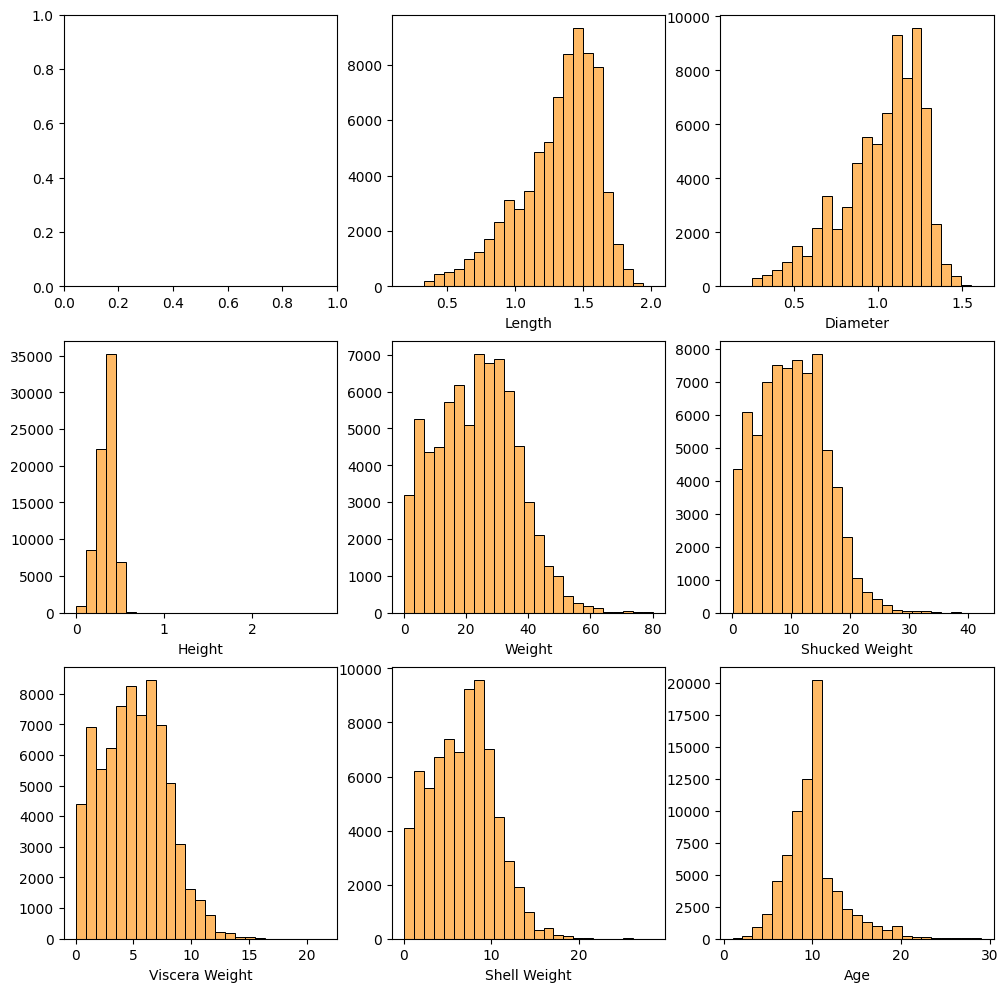

In [ ]:
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 12))

axes = np.reshape(axes, (1, -1))

for i in range(1, n_rows * n_cols):
    sns.histplot(ax=axes[0][i], bins=25, color="darkorange", alpha=0.6,
                 data=data_train[get_attributes_names(data_train, "quant")[i]])
    axes[0][i].set(ylabel=None)

plt.show()

*   Some attributes seem slightly skewed to the right and others to the left.
*   Apparently some attributes have outliers in the direction of the bias.
* All attributes are unimodal and close to be normal.

##Create a train set and test set

The training set will be used to tune the parameters of multiple machine learning algorithms, whereas the test set will be used to evaluate how good the final system is.

In [ ]:
X_train = data_train.drop(["Age"], axis=1)
y_train = data_train["Age"]

In [ ]:
X_test = load_data(DATA_SETS_PATH, "test.csv")

##Correlations between attributes

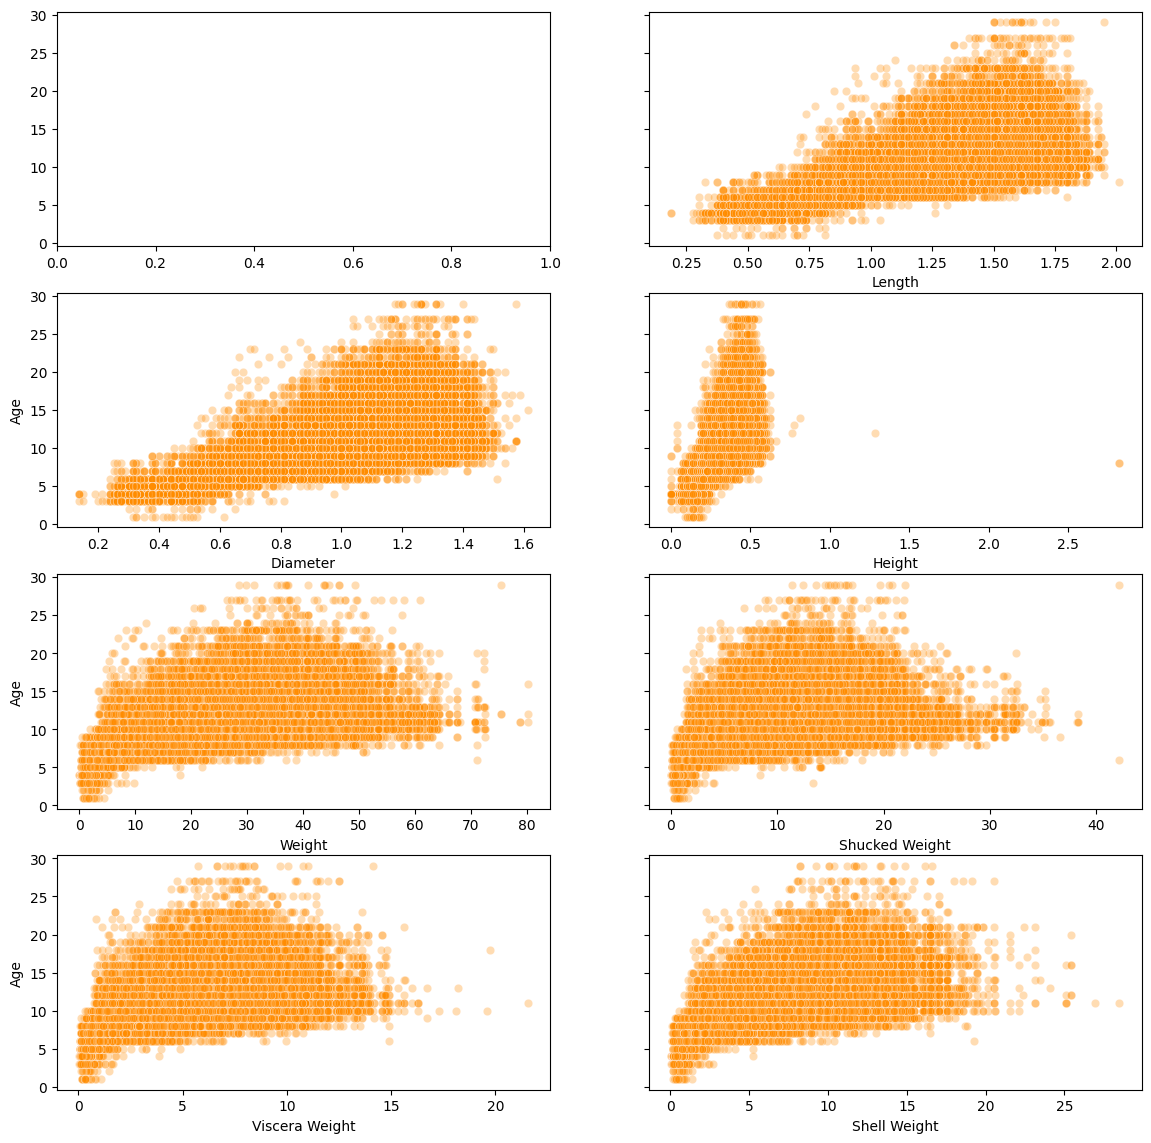

In [ ]:
n_rows = 4
n_cols = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 14), sharey=True)
axes = np.reshape(axes, (1, -1))

for i in range(1, n_rows * n_cols):
    sns.scatterplot(ax=axes[0][i], color="darkorange", alpha=0.3,
                    x=X_train[get_attributes_names(X_train, "quant")[i]],
                    y=y_train)
plt.show()

From the *scatter plots* it is easy to see that there is a linear relationship between the attributes and the target attribute. Large values of the attributes correspond to large values of the target attribute.

It does not mean that there is causality between the attributes, it just means that there may be an underlying common factor that affects both attributes.

In [ ]:
corr_matrix = pd.concat([X_train, y_train], axis=1)[
    get_attributes_names(pd.concat([X_train, y_train], axis=1), "quant")].corr()

In [ ]:
corr_matrix["Age"].sort_values(ascending=False)

Age               1.000000
Shell Weight      0.663473
Height            0.638067
Diameter          0.621256
Length            0.612843
Weight            0.601195
Viscera Weight    0.576808
Shucked Weight    0.503320
id                0.000089
Name: Age, dtype: float64

The values of *Pearson correlation coefficient* show that there is a *moderate linear association* between the attributes and the target attribute.
There is an insignificant linear relation between *Age* and *id* which is expected, due that *id* is not a physical attribute, it only identifies each instance.

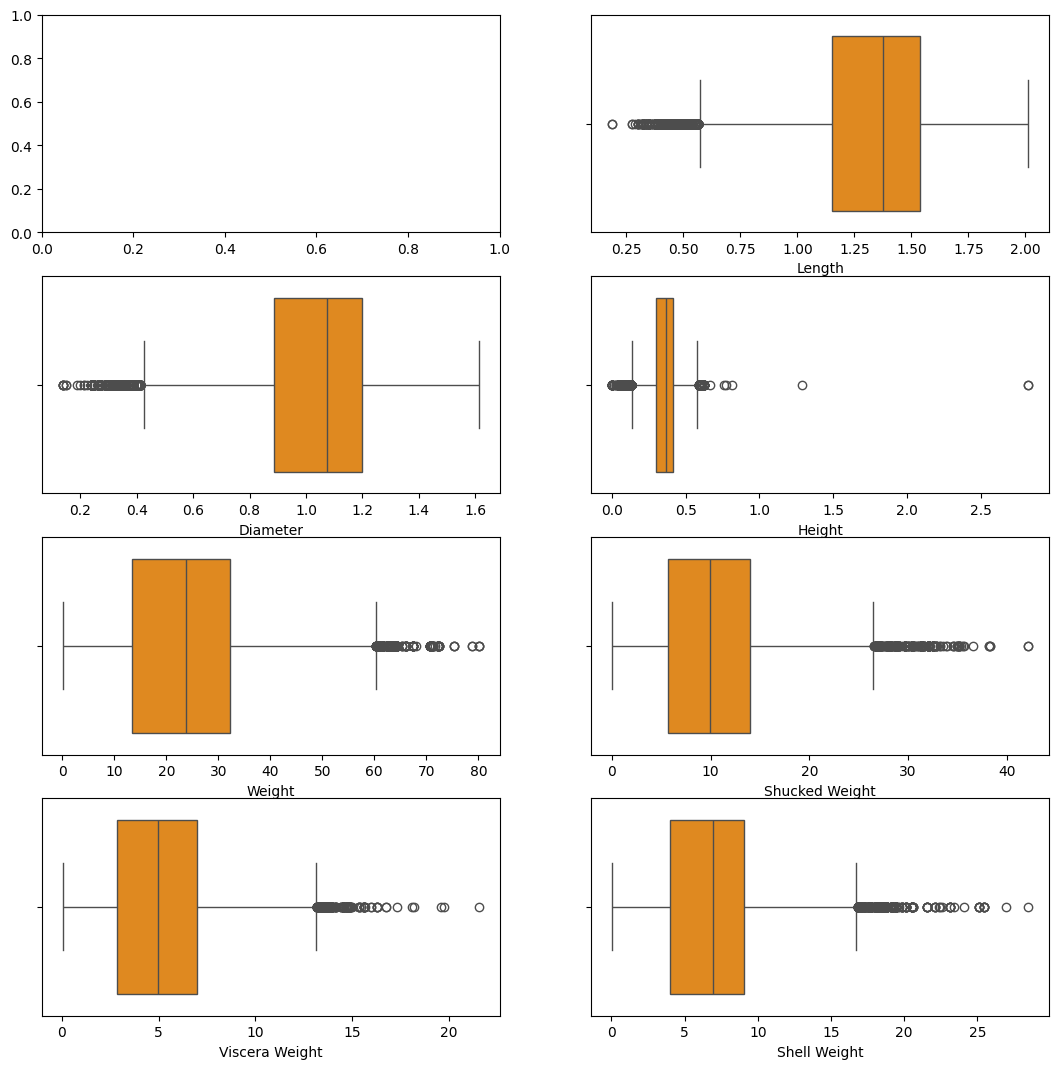

In [ ]:
n_rows = 4
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(13, 13))

axes = np.reshape(axes, (1, -1))

for i in range(1, n_rows * n_cols):
    sns.boxplot(ax=axes[0][i], data=X_train, color="darkorange",
                x=get_attributes_names(X_train, "quant")[i])

plt.show()

There are outliers in every attribute, some attributes have outliers on the right, some have outliers on the left, and one has them on both sides.

##Analysis of Variance

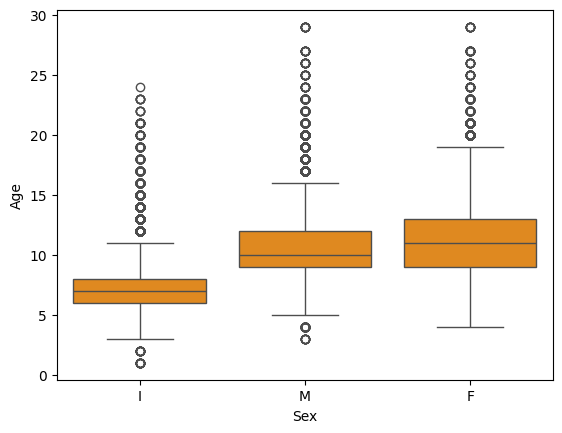

In [ ]:
sns.boxplot(data=pd.concat([X_train[get_attributes_names(X_train, "quali")], y_train], axis=1), x="Sex", y="Age", color="darkorange")
plt.show()

There seems to be a relationship between the *Sex* of the crab and the *Age*, perhaps crabs develop their sexual organs after a certain *Age*, which would explain why those classified as *Indeterminate* have the lowest median.
It may also happen that *Male* crabs have to search and fight for food and space, which would also expose them to a greater extent to predators, leading them to die before *Female* crabs, so the median of *Female* crabs is higher.

In order to determine if the qualitative attribute *Sex* is related with the target attribute *Age* it is neccesary to use the analysis of variance.

Three populations of crabs are established, these are divided according to the assigned sex: *Male, Female, Indeterminate*.

The objective is to determine if there is a significant difference between the *average ages* of these three groups.

Two hypotheses are established
*   $H_{o}$: $\mu_{F} = \mu_{I} = \mu_{M}$
*   $H_{a}$: There is a significant difference in average *Age* between at least two of the crab populations.

This analysis is based on the variance of the data within the groups($MS_{within}$) and the variance between the groups($MS_{between}$). If there is no real difference between the group means, and any differences that may exist are due only to the randomness of sampling, then the $F$ statistic, which is defined as follows:
$$
F = \frac{MS_{between}}{MS_{within}}
$$
will be close to one.

With this statistic $F$, the probability $p$ of obtaining a statistic $F$ greater than or equal to the observed one is calculated, assuming that the null hypothesis $H_{o}$ is true. If the probability $p$ is less than the significance level $\alpha=0.05$, then $H_{o}$ is rejected and $H_{a}$ is accepted.

Set the significance level:

In [ ]:
alpha = 0.05

###Assumptions:
To apply the analysis of variance, it is neccesary to meet certain conditions:

*   The observations are independent, the *Sex* of the crab is independent of the others.

*   The response variable is normally distributed in each group.

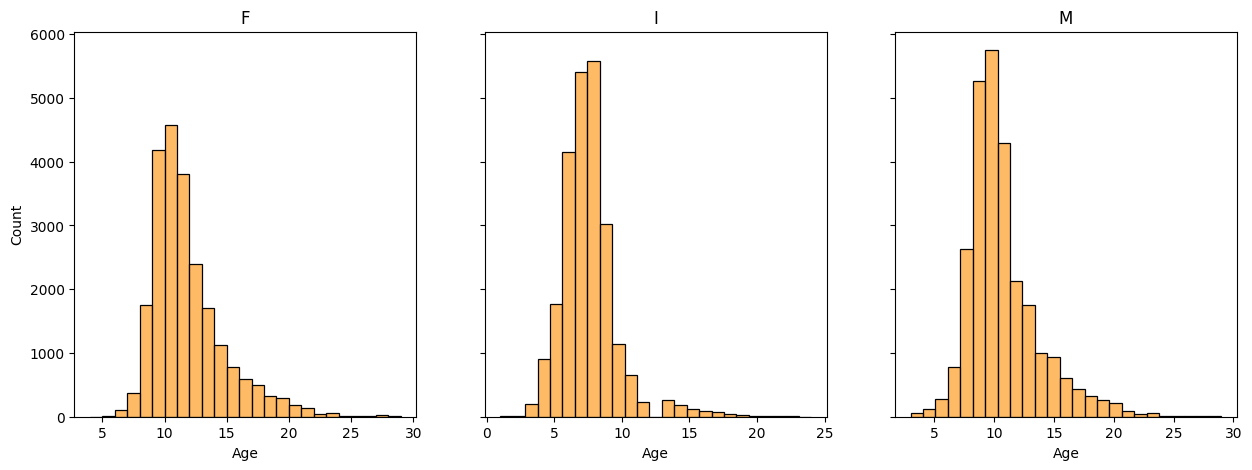

In [ ]:
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5), sharey=True)

groups = list((X_train["Sex"].astype("category")).cat.categories)

for i in range(n_rows * n_cols):
    sns.histplot(ax=axes[i], bins=25, color="darkorange", alpha=0.6,
                 x=(pd.concat([X_train, y_train], axis=1)[X_train["Sex"] == groups[i]])["Age"])
    axes[i].set_title(groups[i])

In [ ]:
X_train["Sex"].value_counts()

M    27084
I    23957
F    23010
Name: Sex, dtype: int64

The *Age* attribute is approximately normally distributed in each group.

Also the sample size of each group is greater than $10$, so moderate violation of normality is not a problem.

*   Homogeneity of variances, it is assumed that the population variance is the same for each group.

In [ ]:
for g in groups:
    std = np.std((pd.concat([X_train["Sex"], y_train], axis=1)[X_train["Sex"] == g])["Age"])
    print("Standard deviation of {}: {}".format(g, std))

Standard deviation of F: 2.9572264402803814
Standard deviation of I: 2.2296287334120874
Standard deviation of M: 2.88266067266373


In the case of unequal group sizes, moderate violation of homogeneity of variances is not a problem if the *largest standard deviation* is less than or equal to twice the *smallest standard deviation*.

In [ ]:
2.9572264402803814 <= 2 * 2.2296287334120874

True

The required assumptios to use the analisys of variances were met.

###Calculation of the statistic *F*

In [ ]:
def var_within(X, groups):
    """Calculate the sum of variances within each group.

    Args:
      X: DataFrame that will be divided according to the groups.
      groups: A list with the name of each group.

    Returns:
      var_w: Sum of variances of each group.
      dof: Degrees of freedom.
    """
    s = 0
    dof = X.shape[0] - len(groups)

    for g in groups:
        s += np.var((X[X["Sex"] == g])["Age"]) * (X[X["Sex"] == g].shape[0])

    var_w = s / dof

    return var_w, dof

In [ ]:
var_w, dof_w = var_within(pd.concat([X_train["Sex"], y_train], axis=1), groups)
var_w, dof_w

(7.365272213084625, 74048)

In [ ]:
def var_between(X, groups):
    """Calculate the variances between groups.

    Args:
      X: DataFrame that will be divided according to the groups.
      groups: A list with the name of each group.

    Returns:
      var_b: Variance between groups.
      dof: Degrees of freedom.
    """
    grand_mean = np.mean(X["Age"])
    dof = len(groups) - 1
    s = 0

    for g in groups:
        s += ((np.mean(X[X["Sex"] == g]["Age"]) - grand_mean) ** 2) * X[X["Sex"] == g].shape[0]

    var_b = s / dof

    return var_b, dof

In [ ]:
var_b, dof_b = var_between(pd.concat([X_train["Sex"], y_train], axis=1), groups)
var_b, dof_b

(100587.78630085461, 2)

Calculate the *F* statistic.

In [ ]:
F = var_b / var_w
F

13657.035801359443

###Calculation of the *p-value*

In [ ]:
import scipy

In [ ]:
p_value = 1 - scipy.stats.f.cdf(F, dof_b, dof_w)
p_value

1.1102230246251565e-16

In [ ]:
p_value <= alpha

True

Because the *p-value* is less than the significance level $\alpha$, the null hypothesis $H_{o}$ is rejected and the alternative hypothesis $H_{a}$ is accepted, and it is concluded that at least one of the *Sex* groups differs from the others in terms of average *Age*, so *Sex* and *Age* are related.

#PREPARE THE DATA

##Quantitative attributes

In [ ]:
X_train.head(3)

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,0,I,1.5250,1.1750,0.375,28.973189,12.728926,6.647958,8.348928
1,1,I,1.1000,0.8250,0.275,10.418441,4.521745,2.324659,3.401940
2,2,M,1.3875,1.1125,0.375,24.777463,11.339800,5.556502,6.662133


In [ ]:
from sklearn.preprocessing import FunctionTransformer

The first step is to eliminate irrelevant attributes, in this project the irrelevant attribute is *id*, which has a *Pearson correlation coefficient* of only $0.000089$.

In [ ]:
def delete_columns(X, columns):
    """Delete a list of columns from the Dataframe.

    Args:
      X: Dataframe.
      columns: Columns to be removed.

    Returns:
      X: Reduced DataFrame.
    """
    X = X.drop(columns, axis=1)

    return X

In [ ]:
remove_irr_attribs = FunctionTransformer(delete_columns, kw_args=dict(columns=["id"]))

In [ ]:
X_train = remove_irr_attribs.fit_transform(X_train)

In [ ]:
X_train.head(3)

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,I,1.5250,1.1750,0.375,28.973189,12.728926,6.647958,8.348928
1,I,1.1000,0.8250,0.275,10.418441,4.521745,2.324659,3.401940
2,M,1.3875,1.1125,0.375,24.777463,11.339800,5.556502,6.662133


Attributes have a distribution that is slightly skewed to the left or right.

These attributes will be transformed to be more *Gaussian*.

*Left skewed* attributes will be transformed with the *square* function of *numpy*.

In [ ]:
left_skewed_attribs = ["Length", "Diameter"]

In [ ]:
attribs_squared = FunctionTransformer(np.square)

In [ ]:
X_train[left_skewed_attribs] = attribs_squared.fit_transform(X_train[left_skewed_attribs])

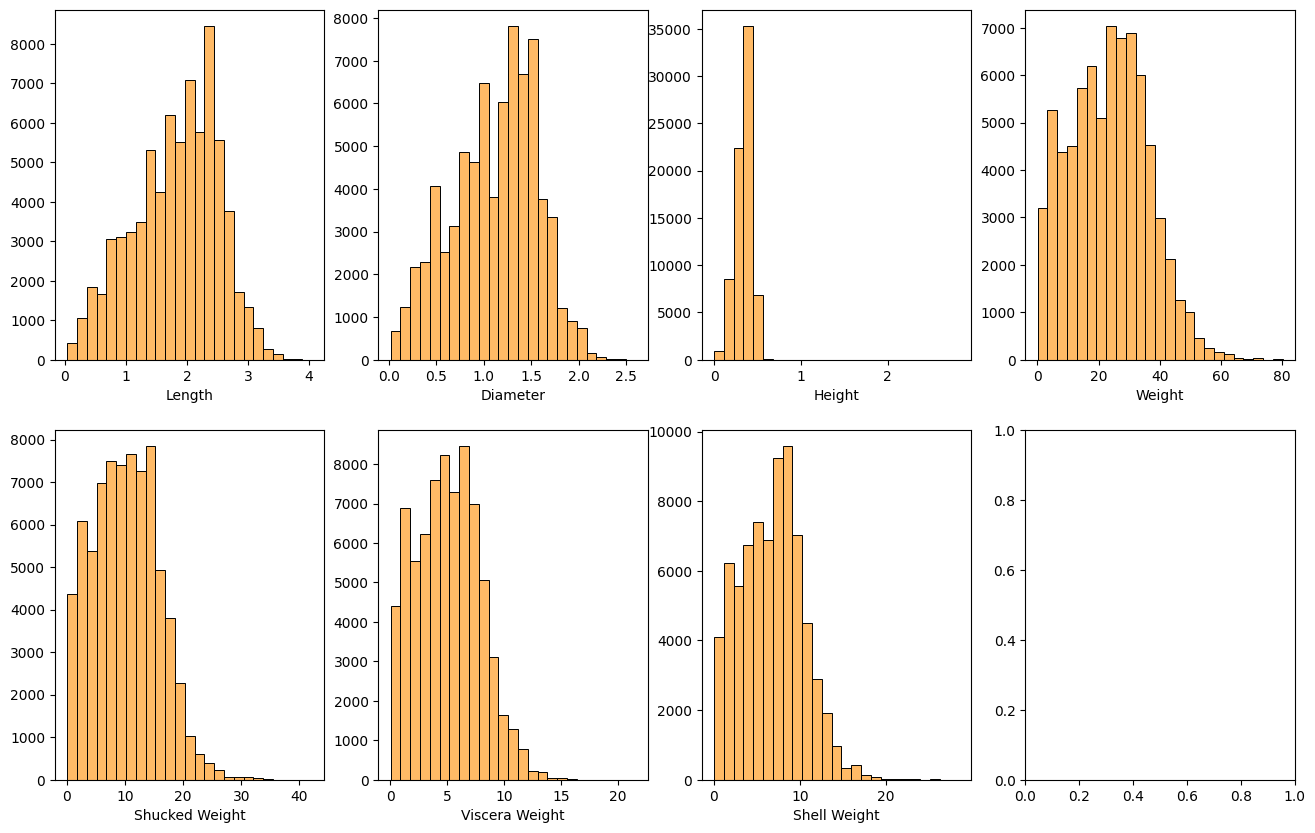

In [ ]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 10))

axes = np.reshape(axes, (1, -1))

for i in range(0, n_rows * n_cols-1):
    sns.histplot(ax=axes[0][i], bins=25, color="darkorange", alpha=0.6,
                 data=X_train[get_attributes_names(X_train, "quant")[i]])
    axes[0][i].set(ylabel=None)

plt.show()

Right skewed attributes will be transformed with the *sqrt* function of *numpy*.

In [ ]:
right_skewed_attribs = list(set(get_attributes_names(X_train, "quant")) - set(left_skewed_attribs))

In [ ]:
square_root_attribs = FunctionTransformer(np.sqrt)

In [ ]:
X_train[right_skewed_attribs] = square_root_attribs.fit_transform(X_train[right_skewed_attribs])

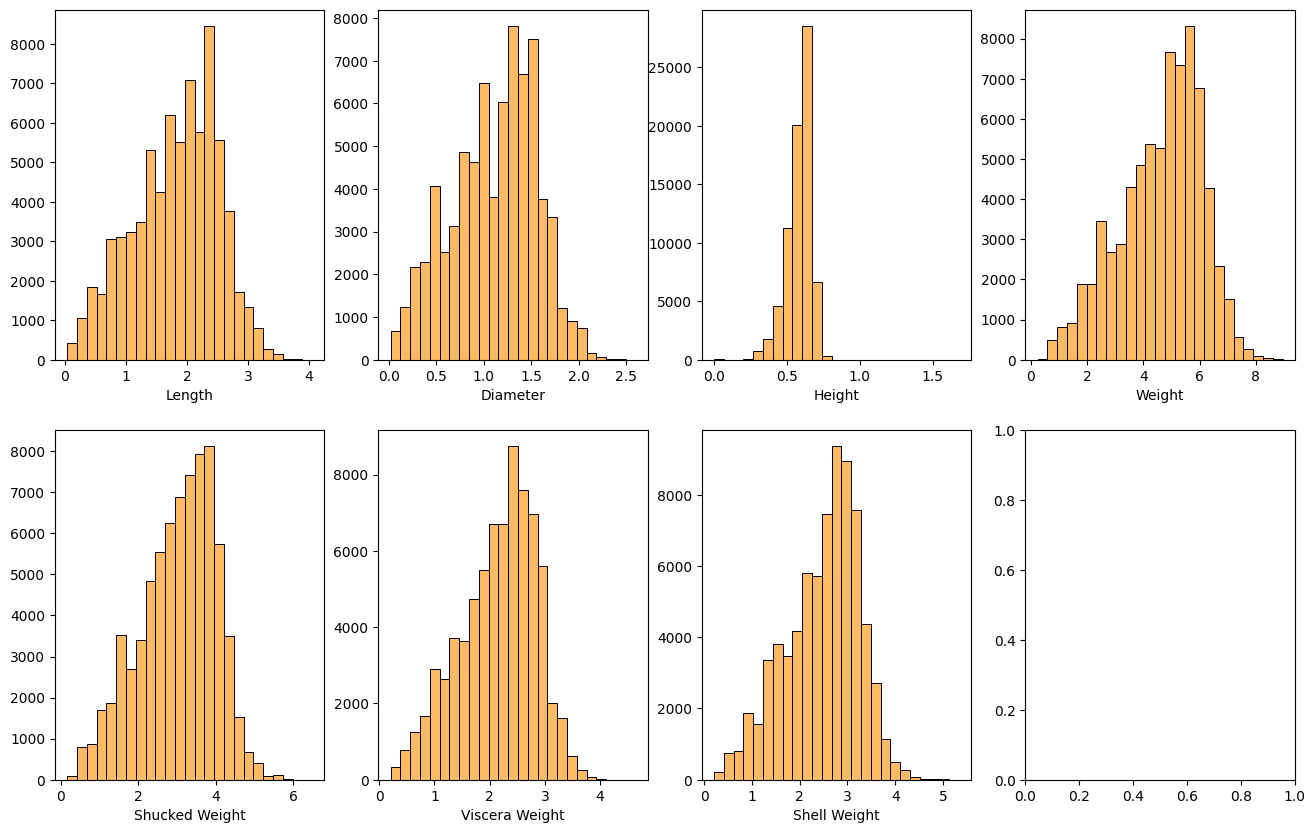

In [ ]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 10))

axes = np.reshape(axes, (1, -1))

for i in range(0, n_rows * n_cols-1):
    sns.histplot(ax=axes[0][i], bins=25, color="darkorange", alpha=0.6,
                 data=X_train[get_attributes_names(X_train, "quant")[i]])
    axes[0][i].set(ylabel=None)

plt.show()

The attributes look more *Normal*.

Finally, the quantitative attributes will be standardized so that they have a mean of $0$ and a variance equal to $1$.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
std_scaler = StandardScaler()

In [ ]:
X_train[get_attributes_names(X_train, "quant")] = std_scaler.fit_transform(X_train[get_attributes_names(X_train, "quant")])

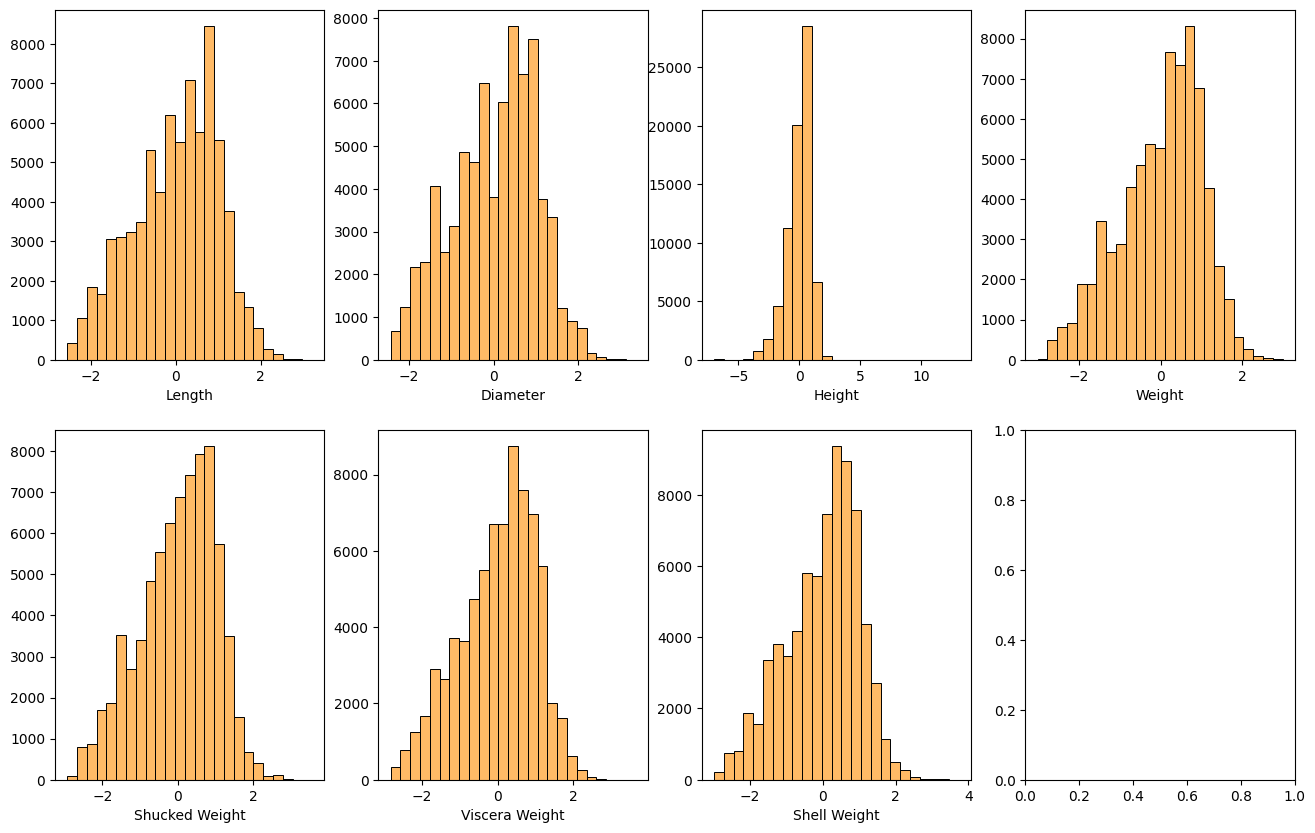

In [ ]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 10))

axes = np.reshape(axes, (1, -1))

for i in range(0, n_rows * n_cols-1):
    sns.histplot(ax=axes[0][i], bins=25, color="darkorange", alpha=0.6,
                 data=X_train[get_attributes_names(X_train, "quant")[i]])
    axes[0][i].set(ylabel=None)

plt.show()

##Qualitative attributes

Machine learning algorithms work best with numbers as data, so *qualitative attributes* will be encoded. Because the *Sex* attribute contains more than two possible values, *One-Hot encoding* will be used.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe_encod = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

In [ ]:
X_ohe = ohe_encod.fit_transform(X_train[get_attributes_names(X_train, "quali")])

In [ ]:
X_ohe.head(3)

,Sex_F,Sex_I,Sex_M
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [ ]:
X_train = pd.concat([X_train, X_ohe], axis=1).drop(columns=X_train[get_attributes_names(X_train, "quali")])

In [ ]:
X_train.head(3)

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,0.728502,0.615808,0.339431,0.530269,0.556528,0.636510,0.538650,0.0,1.0,0.0
1,-0.874143,-0.953549,-0.715521,-0.953671,-0.924030,-0.900849,-0.829286,0.0,1.0,0.0
2,0.153211,0.295281,0.339431,0.251388,0.350775,0.313858,0.135029,0.0,0.0,1.0


Finally, the *DataFrames X_train and y_train* are going to be transformed into a *numpy array*, to be introduced into the different *Machine Learning* algorithms.

In [ ]:
X_train = X_train.to_numpy()

In [ ]:
y_train = y_train.to_numpy()

#SHORTLIST PROMISING MODELS

sample the *training set* to train different machine learning algorithms on it, which will be faster than training them on the full *training set*.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
_, X_train_sample, _, y_train_sample = train_test_split(X_train, y_train, test_size=20000, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
def display_scores(scores):
    """Print scores, mean and standard deviation of these.

    Args:
      scores: List of Machine Learning algorithm scores in the validation set.
    """
    print("Scores: {}".format(scores))
    print("Mean: {}".format(round(np.mean(scores), 3)))
    print("Standard deviation: {}".format(round(np.std(scores), 3)))

##Machine Learning Algorithms

*   *Linear Regression*

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lin_reg = LinearRegression()

In [ ]:
lin_reg_scores = -cross_val_score(lin_reg, X_train_sample, y_train_sample,
                                  scoring="neg_mean_absolute_error", cv=5)

In [ ]:
display_scores(lin_reg_scores)

Scores: [1.4837242  1.48933957 1.46861435 1.47972815 1.454891  ]
Mean: 1.475
Standard deviation: 0.012


*   *Decision Tree*

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree_reg = DecisionTreeRegressor()

In [ ]:
tree_reg_scores = -cross_val_score(tree_reg, X_train_sample, y_train_sample,
                                  scoring="neg_mean_absolute_error", cv=5)

In [ ]:
display_scores(tree_reg_scores)

Scores: [1.98775 2.0525  2.0075  1.98725 2.00825]
Mean: 2.009
Standard deviation: 0.024


*   *Random Forest*

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
forest_reg = RandomForestRegressor()

In [ ]:
forest_reg_scores = -cross_val_score(forest_reg, X_train_sample, y_train_sample,
                                     scoring="neg_mean_absolute_error", cv=5)

In [ ]:
display_scores(forest_reg_scores)

Scores: [1.4814425 1.504905  1.4900375 1.504015  1.4610175]
Mean: 1.488
Standard deviation: 0.016


*   *Support Vector Machine*

In [ ]:
from sklearn.svm import SVR

In [ ]:
svm_reg = SVR()

In [ ]:
svm_reg_scores = -cross_val_score(svm_reg, X_train_sample, y_train_sample,
                                     scoring="neg_mean_absolute_error", cv=5)

In [ ]:
display_scores(svm_reg_scores)

*   *Neural Network*

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
nn_reg = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(10,)),
    keras.layers.Dense(30, activation=keras.activations.relu),
    keras.layers.Dense(30, activation=keras.activations.relu),
    keras.layers.Dense(30, activation=keras.activations.relu),
    keras.layers.Dense(1, activation=keras.activations.relu)
])

In [ ]:
nn_reg.compile(loss="mae", optimizer=keras.optimizers.Adam(),
              metrics=["mean_absolute_error"])

In [ ]:
history = nn_reg.fit(X_train_sample, y_train_sample, epochs=5, validation_split=0.2)

Epoch 1/5
500/500 [==============================] - 2s 2ms/step - loss: 2.8627 - mean_absolute_error: 2.8627 - val_loss: 1.4198 - val_mean_absolute_error: 1.4198
Epoch 2/5
500/500 [==============================] - 1s 2ms/step - loss: 1.4439 - mean_absolute_error: 1.4439 - val_loss: 1.4005 - val_mean_absolute_error: 1.4005
Epoch 3/5
500/500 [==============================] - 1s 2ms/step - loss: 1.4276 - mean_absolute_error: 1.4276 - val_loss: 1.3934 - val_mean_absolute_error: 1.3934
Epoch 4/5
500/500 [==============================] - 1s 2ms/step - loss: 1.4290 - mean_absolute_error: 1.4290 - val_loss: 1.4224 - val_mean_absolute_error: 1.4224
Epoch 5/5
500/500 [==============================] - 2s 3ms/step - loss: 1.4235 - mean_absolute_error: 1.4235 - val_loss: 1.3822 - val_mean_absolute_error: 1.3822


In [ ]:
nn_reg_scores = history.history["val_mean_absolute_error"]

In [ ]:
display_scores(nn_reg_scores)

Scores: [1.4198129177093506, 1.4005099534988403, 1.3934261798858643, 1.422385334968567, 1.3821591138839722]
Mean: 1.404
Standard deviation: 0.015


The algorithms which have the best performance are:
*   *Support Vector Machine*: $1.393$
*   *Neural Network*: $1.398$

#FINE-TUNE THE SYSTEM

##Fine-Tune the *Neural Network*

*Random Search* is used to find the best hyperparameters of the *Neural Network*.

In [ ]:
%pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=10, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(10,)))

    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))

    model.add(keras.layers.Dense(1, activation="relu"))

    model.compile(loss="mae", optimizer=optimizer, metrics=["mean_absolute_error"])

    return model

In [ ]:
random_search_tuner = kt.RandomSearch(build_model, objective="mean_absolute_error",
                                      project_name="my_rnd_search", overwrite=False,
                                      max_trials=5, seed=42)

Reloading Tuner from ./my_rnd_search/tuner0.json


The best hyperparameters

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 09 summary
Hyperparameters:
n_hidden: 7
n_neurons: 235
learning_rate: 0.00044412650444693207
Score: 1.3810991048812866


##Fine-Tune the *SVM*

*Grid Search* is used to find the best hyperparameters of the *Support Vector Machine*.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [
    {"degree": [1, 2], 'C': [0.1, 1, 10], "epsilon": [0.1, 1, 10]}
]

In [ ]:
svm_reg = SVR(kernel="poly")

In [ ]:
grid_search = GridSearchCV(svm_reg, param_grid, cv=2, scoring="neg_mean_absolute_error",
                           return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVR(kernel='poly'),
             param_grid=[{'C': [0.1, 1, 10], 'degree': [1, 2],
                          'epsilon': [0.1, 1, 10]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

The best hyperparameters.

In [ ]:
grid_search.best_params_

{'C': 10, 'degree': 2, 'epsilon': 0.1}

Scores.

In [ ]:
cvres = grid_search.cv_results_

In [ ]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

1.4394611401498474 {'C': 0.1, 'degree': 1, 'epsilon': 0.1}
1.444236717417783 {'C': 0.1, 'degree': 1, 'epsilon': 1}
5.359544904718697 {'C': 0.1, 'degree': 1, 'epsilon': 10}
1.4579797719144016 {'C': 0.1, 'degree': 2, 'epsilon': 0.1}
1.4752198377535868 {'C': 0.1, 'degree': 2, 'epsilon': 1}
5.696057916619758 {'C': 0.1, 'degree': 2, 'epsilon': 10}
1.4359056530735796 {'C': 1, 'degree': 1, 'epsilon': 0.1}
1.4409960252859835 {'C': 1, 'degree': 1, 'epsilon': 1}
5.282863594142803 {'C': 1, 'degree': 1, 'epsilon': 10}
1.4030560401413528 {'C': 1, 'degree': 2, 'epsilon': 0.1}
1.412173051127795 {'C': 1, 'degree': 2, 'epsilon': 1}
5.675566924466617 {'C': 1, 'degree': 2, 'epsilon': 10}
1.435784300645529 {'C': 10, 'degree': 1, 'epsilon': 0.1}
1.4413412636537224 {'C': 10, 'degree': 1, 'epsilon': 1}
5.16473870931005 {'C': 10, 'degree': 1, 'epsilon': 10}
1.3976273477117456 {'C': 10, 'degree': 2, 'epsilon': 0.1}
1.404308136915056 {'C': 10, 'degree': 2, 'epsilon': 1}
5.457846546356412 {'C': 10, 'degree': 2, 

##Ensemble Methods

Generally, *Ensemble Methods* perform better than individual models. Here, the *Neural Network* and *Support Vector Machine* models are going to be trained with the *Training Set* and the best hyperparameters. The final predictions will be an average of the predictions from each individual model.

In [ ]:
%pip install -q -U scikeras

In [ ]:
from scikeras.wrappers import KerasRegressor

In [ ]:
def build_nn():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(10,)))

    for _ in range(7):
        model.add(keras.layers.Dense(235, activation="relu"))
    model.add(keras.layers.Dense(1, activation="relu"))

    model.compile(loss="mae", metrics=["mean_absolute_error"],
                  optimizer=keras.optimizers.Adam(learning_rate=0.00044412650444693207))

    return model

In [ ]:
best_nn_reg = KerasRegressor(model=build_nn, epochs=15, verbose=False)

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
svm_reg = SVR(kernel="poly", degree=2, C=10, epsilon=0.1)

In [ ]:
voting_reg = VotingRegressor(
    estimators=[("svm_reg", svm_reg), ("nn_reg", nn_reg)]
)

Train the Ensemble Model with the *Training Set*.

In [ ]:
voting_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('svm_reg', SVR(C=10, degree=2, kernel='poly')),
                            ('nn_reg',
                             KerasRegressor(epochs=15, model=<function build_nn at 0x7c6541d74ee0>, verbose=False))])

#PREDICT THE AGE OF CRABS

##Transform the *Test Set*.

In [ ]:
X_test_n = X_test.copy()

In [ ]:
X_test_n = remove_irr_attribs.transform(X_test_n)
X_test_n[left_skewed_attribs] = attribs_squared.transform(X_test_n[left_skewed_attribs])
X_test_n[right_skewed_attribs] = square_root_attribs.transform(X_test_n[right_skewed_attribs])
X_test_n[get_attributes_names(X_test_n, "quant")] = std_scaler.transform(X_test_n[get_attributes_names(X_test_n, "quant")])

In [ ]:
X_ohe_t = ohe_encod.transform(X_test_n[get_attributes_names(X_test_n, "quali")])
X_test_n = pd.concat([X_test_n, X_ohe_t], axis=1).drop(columns=X_test_n[get_attributes_names(X_test_n, "quali")])

In [ ]:
X_test_n = X_test_n.to_numpy()

##Prediction

In [ ]:
y_hat_test = voting_reg.predict(X_test_n)

#SUBMIT TO KAGGLE

In [ ]:
submission = pd.DataFrame([X_test["id"], y_hat_test]).T

In [ ]:
submission.columns = ["id", "Age"]

In [ ]:
submission["id"] = submission["id"].astype("Int32")

In [ ]:
submission.head()

,id,Age
0,74051,7.231535
1,74052,7.869159
2,74053,10.075368
3,74054,9.311308
4,74055,7.588256


In [ ]:
submission.to_csv("Crab_Age_Submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c playground-series-s3e16 -f Crab_Age_Submission.csv -m "final"

100% 1.17M/1.17M [00:00<00:00, 1.26MB/s]
Successfully submitted to Regression with a Crab Age Dataset

A mean absolute error of $1.37693$ is achieved in the *Test Set*, indicating that on average the error in the crab age predictions will be $1.37693$ months.

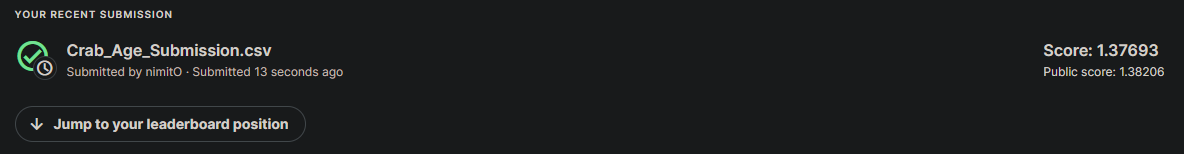